### Load libraries

In [1]:
# Importing auxiliary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime

# import pytorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader


# import tensorboard for logging
from torch.utils.tensorboard import SummaryWriter

# importing local code
import sys
sys.path.append('../')
from datasets import SpectraDataset
from models import SimpleMLP, FlexibleMLP, ResidualMLP
from loops import train,val

### Define params

In [2]:
hidden_layers = [5, 500, 500, 500, 500, 500, 200]  # structure of the neural network

### Prepare datasets

#### Load data into dataframe and clean them

In [3]:
# filename
filename = '../DL-Assisted-NHA-Inverse-Design-/Dataset 6655.csv'

# load in dataframe
df = pd.read_csv(filename)

# clean and rearrange data
df['Spectra'] = df.values[:,5:][:,::-1].tolist()
df['Spectra'] = df['Spectra'].apply(np.array)
df.drop(df.columns[5:-1], axis=1, inplace=True)
df.columns = ['Lattice','Material','Thickness','Radius','Pitch','Spectra']

#### Split dataframe in train/val and features/labels (X/y) 

In [4]:
# select and normalize input features (X)
X_df = df[['Lattice','Material','Thickness','Radius','Pitch']]
X_df = X_df/X_df.max()

# select output labels (y)
y_df = df['Spectra']

# split in training and validation set
test_val_split = 0.1  # portion of data assigned to validation set
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=test_val_split, random_state=42)

In [5]:
X_train

,Lattice,Material,Thickness,Radius,Pitch
4851,1.0,0.0,0.900000,0.700000,0.914286
604,0.0,0.0,0.833333,0.666667,0.904762
3891,0.0,1.0,1.000000,0.333333,0.990476
4817,1.0,0.0,0.866667,0.966667,0.904762
4047,1.0,0.0,0.666667,0.833333,0.904762
...,...,...,...,...,...
3772,0.0,1.0,0.966667,0.366667,0.904762
5191,1.0,0.0,0.966667,1.000000,0.904762
5226,1.0,0.0,1.000000,0.733333,0.923810
5390,1.0,0.5,0.666667,0.866667,0.914286


In [6]:
X_val

,Lattice,Material,Thickness,Radius,Pitch
5896,1.0,0.5,0.800000,0.933333,0.914286
217,0.0,0.0,0.700000,0.566667,0.990476
3214,0.0,1.0,0.800000,0.500000,0.933333
4516,1.0,0.0,0.800000,0.766667,0.971429
1544,0.0,0.5,0.700000,0.566667,0.952381
...,...,...,...,...,...
425,0.0,0.0,0.766667,0.466667,0.980952
4382,1.0,0.0,0.766667,0.733333,0.952381
1002,0.0,0.0,0.933333,0.400000,0.923810
681,0.0,0.0,0.833333,0.533333,0.904762


In [7]:
X_val

,Lattice,Material,Thickness,Radius,Pitch
5896,1.0,0.5,0.800000,0.933333,0.914286
217,0.0,0.0,0.700000,0.566667,0.990476
3214,0.0,1.0,0.800000,0.500000,0.933333
4516,1.0,0.0,0.800000,0.766667,0.971429
1544,0.0,0.5,0.700000,0.566667,0.952381
...,...,...,...,...,...
425,0.0,0.0,0.766667,0.466667,0.980952
4382,1.0,0.0,0.766667,0.733333,0.952381
1002,0.0,0.0,0.933333,0.400000,0.923810
681,0.0,0.0,0.833333,0.533333,0.904762


In [8]:
y_train

4851    [0.0177678, 0.0183766, 0.0188949, 0.0193357, 0...
604     [0.0605793, 0.0606152, 0.05966, 0.0578818, 0.0...
3891    [0.808406, 0.809849, 0.809093, 0.813381, 0.814...
4817    [0.0190139, 0.0184199, 0.0178838, 0.0173684, 0...
4047    [0.0225713, 0.0216366, 0.020792, 0.0200721, 0....
                              ...                        
3772    [0.859133, 0.864281, 0.86973, 0.871492, 0.8704...
5191    [0.0287532, 0.0295561, 0.0304197, 0.0313051, 0...
5226    [0.00877991, 0.00827171, 0.00775168, 0.0072616...
5390    [0.0210184, 0.0225432, 0.0239345, 0.0252061, 0...
860     [0.00322914, 0.003215, 0.00319104, 0.00315318,...
Name: Spectra, Length: 5988, dtype: object

In [9]:
y_val

5896    [0.0211472, 0.0229053, 0.0245804, 0.0261867, 0...
217     [0.0477382, 0.0480398, 0.0481729, 0.0483546, 0...
3214    [0.984692, 0.986608, 0.988734, 0.986776, 0.989...
4516    [0.019098, 0.0185224, 0.0178235, 0.0170732, 0....
1544    [0.0949851, 0.0943849, 0.0933566, 0.0924849, 0...
                              ...                        
425     [0.0150305, 0.0148046, 0.014522, 0.0143151, 0....
4382    [0.0157072, 0.016587, 0.0175634, 0.0185691, 0....
1002    [0.00339143, 0.00332585, 0.00328501, 0.0032520...
681     [0.0225218, 0.022542, 0.0223468, 0.021951, 0.0...
5719    [0.0261101, 0.0269595, 0.0279326, 0.0289608, 0...
Name: Spectra, Length: 666, dtype: object

#### Create datasets

In [10]:
# instantiate training and validation dataset
training_dataset = SpectraDataset(X_train,y_train)
val_dataset = SpectraDataset(X_val,y_val)

#### Create dataloaders

In [11]:
# batch size
batch_size = 64

# Create data loaders
train_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle= True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, pin_memory=True)

for X, y in val_dataloader:
    print(f"Shape of X [N, C]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C]: torch.Size([64, 5])
Shape of y: torch.Size([64, 200]) torch.float32


### Training

#### Choosing training device: cpu, gpu, etc...

In [12]:
# Get cpu or gpu device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Define model

In [13]:
model = FlexibleMLP(hidden_layers=hidden_layers, activation=nn.GELU(), p=0.1).to(
    device
)
# model = SimpleMLP().to(device)
# model = ResidualMLP(hidden_layers=hidden_layers).to(device)

#### Defining loss and optimizer

In [14]:
# base learning rate
lr = 1.1e-4

# defining loss and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

#### Run optimization loop

In [15]:
# create timestamp
now = datetime.now()  # current date and time
date_time = now.strftime("%d%m%y_%H%M%S")

# create summary writer for tensorboard
writer_path = '../tb_logs/' + date_time + '/'
writer = SummaryWriter(writer_path)

# loop over epochs
epochs = 4000
epoch_threshold = 500
save_checkpoint = './best_model.ckpt'
best_loss = 1.0
for epoch in range(epochs):

    # log epoch to console
    print(f"Epoch {epoch+1}\n-------------------------------")

    # performe training and validation loops
    train_loss = train(train_dataloader, model, loss_fn, optimizer, device)
    val_loss = val(val_dataloader, model, loss_fn, device)

    # log training and validation loss to console
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)

    # save checkpoint
    if (val_loss < best_loss) and (epoch>epoch_threshold):
        
        # save checkpoint
        model.train()
        torch.save(model.state_dict(), save_checkpoint)
        best_loss = val_loss

# close connection to tensorboard
writer.flush()
writer.close()

# finished
print("Done!")

Epoch 1
-------------------------------
Train loss: 0.106378  [   64/ 5988]


Validation loss: 0.010192 

Epoch 2
-------------------------------
Train loss: 0.012888  [   64/ 5988]


Validation loss: 0.004345 

Epoch 3
-------------------------------
Train loss: 0.007397  [   64/ 5988]


Validation loss: 0.003832 

Epoch 4
-------------------------------
Train loss: 0.005996  [   64/ 5988]


Validation loss: 0.003837 

Epoch 5
-------------------------------
Train loss: 0.007707  [   64/ 5988]


Validation loss: 0.003663 

Epoch 6
-------------------------------
Train loss: 0.007098  [   64/ 5988]


Validation loss: 0.003831 

Epoch 7
-------------------------------
Train loss: 0.004166  [   64/ 5988]


Validation loss: 0.003806 

Epoch 8
-------------------------------
Train loss: 0.004834  [   64/ 5988]


Validation loss: 0.003571 

Epoch 9
-------------------------------
Train loss: 0.003962  [   64/ 5988]


Validation loss: 0.004088 

Epoch 10
-------------------------------
Train

In [16]:
model.eval()

FlexibleMLP(
  (layers): ModuleList(
    (0): BaseBlock(
      (linear): Linear(in_features=5, out_features=500, bias=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
    (1-4): 4 x BaseBlock(
      (linear): Linear(in_features=500, out_features=500, bias=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
    )
  )
  (final_block): LinearBlock(
    (linear): Linear(in_features=500, out_features=200, bias=False)
  )
)

In [17]:
iter_val = iter(val_dataloader)
val_sample = next(iter_val)

In [18]:
val_sample

[tensor([[1.0000, 0.5000, 0.8000, 0.9333, 0.9143],
         [0.0000, 0.0000, 0.7000, 0.5667, 0.9905],
         [0.0000, 1.0000, 0.8000, 0.5000, 0.9333],
         [1.0000, 0.0000, 0.8000, 0.7667, 0.9714],
         [0.0000, 0.5000, 0.7000, 0.5667, 0.9524],
         [0.0000, 0.0000, 0.7333, 0.6667, 0.9619],
         [1.0000, 0.5000, 0.9333, 0.7333, 0.9524],
         [0.0000, 0.0000, 0.7000, 0.6333, 0.9048],
         [1.0000, 0.0000, 0.9000, 0.7667, 1.0000],
         [1.0000, 0.0000, 0.8333, 0.9000, 0.9048],
         [0.0000, 0.5000, 0.7000, 0.3667, 0.9429],
         [1.0000, 0.5000, 0.9000, 0.8333, 0.9238],
         [0.0000, 0.0000, 0.9333, 0.5000, 0.9524],
         [0.0000, 0.5000, 0.8333, 0.4000, 0.9333],
         [1.0000, 0.5000, 0.7333, 0.6667, 0.9143],
         [0.0000, 1.0000, 0.9000, 0.5333, 0.9429],
         [1.0000, 0.5000, 1.0000, 0.8667, 0.9143],
         [0.0000, 0.0000, 0.9667, 0.5667, 0.9714],
         [1.0000, 0.5000, 1.0000, 0.9000, 0.9810],
         [1.0000, 0.5000, 1.000

In [55]:
n_sample = 2
val_feature = val_sample[0][n_sample:n_sample+1]
val_label = val_sample[1][n_sample:n_sample+1]
nn_label = model(val_feature.to(device))

In [56]:
val_feature

tensor([[0.0000, 1.0000, 0.8000, 0.5000, 0.9333]])

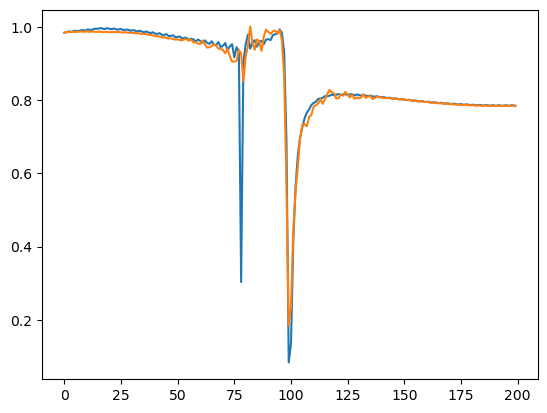

In [57]:
plt.plot(val_label.T)
plt.plot(nn_label.cpu().detach().T)

In [58]:
torch.sum((val_label-nn_label.cpu())**2)/200

tensor(0.0023, grad_fn=<DivBackward0>)